In [1]:
import numpy as np  
from matplotlib import pyplot as plt
import torch
from torch.utils.data import DataLoader, TensorDataset
from torch import nn
from torch.nn import functional as F
import random

In [27]:
n = 1000 #number of points

a, b = -1, 1 #edges of the segment

x = np.linspace(a, b, n)
y = np.sin(10 * x)

part = 0.1
size = round(part * n) #size of train dataset

pairs = list(zip(x, y))

random.shuffle(pairs)

x = np.array([elem[0] for elem in pairs])
y = np.array([elem[1] for elem in pairs])

train_batch_size = 64
valid_batch_size = 64

x_train = torch.FloatTensor(x[:size].reshape(-1, 1))
y_train = torch.FloatTensor(y[:size].reshape(-1, 1))

x_val = torch.FloatTensor(x[size:].reshape(-1, 1))
y_val = torch.FloatTensor(y[size:].reshape(-1, 1))

In [28]:
train_dataset = TensorDataset(x_train, y_train)
val_dataset = TensorDataset(x_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True, drop_last=False)
val_loader = DataLoader(val_dataset, batch_size=valid_batch_size, shuffle=False, drop_last=False)

loaders = {"train": train_loader, "valid": val_loader}

In [29]:
class SimpleNN(nn.Module):
    
    '''
    
    Fully connected neural network. Parameter k sets the depth  
    of neural network. Here we use only linear layers and RELU activation
       
    '''
    
    def __init__(self, k):
        super().__init__()
        
        self.fc = torch.nn.ModuleList([])
        self.k = k

        self.fc.append(nn.Linear(1, 100))
        
        for _ in range(1, k):        
            self.fc.append(nn.Linear(100, 100))
            
        self.fc.append(nn.Linear(100, 1))
            

    def forward(self, x):

        k = self.k
        
        x = self.fc[0](x)
        
        x = F.relu(x)
        
        for i in range(1, k):
            x = self.fc[i](x)
            x = F.relu(x)
        
        x = self.fc[k](x)
        
        return x

In [30]:
def MyFit(model, loaders, opt, crit, max_epochs, device, train_batch_size):
  
    criterion = crit
    optimizer = opt
    losses = {"train": [], "valid": []}
   

    for epoch in range(max_epochs):

        for type, dataloader in loaders.items():
            
            run_loss = 0
            all = 0
            
            for x_batch, y_batch in dataloader:
                
                if type == "train":
                    
                    model.train()
                    
                    optimizer.zero_grad()
                    
                    outp = model(x_batch.to(device))

                    y_batch = y_batch.reshape(-1, 1)

                    y_batch = y_batch.type_as(outp)

                    loss = criterion(outp, y_batch.to(device))
                    loss.backward() 
                    
                    optimizer.step()              
                else:
                    
                    model.eval()
                    
                    with torch.no_grad():
                        
                        outp = model(x_batch.to(device))
                    
                        y_batch = y_batch.reshape(-1, 1)
                        y_batch = y_batch.type_as(outp)

                        loss = criterion(outp, y_batch.to(device))

                run_loss += loss.item() * train_batch_size   
                all += train_batch_size
                       

            losses[type].append(run_loss / all)

    return losses

In [31]:
device = torch.device('cpu')

N_models = 8

simple_model = [0 for i in range(N_models)]

losses = {}


# train models
for i in range(1, N_models + 1):
    
    simple_model[i - 1] = SimpleNN(i)
    simple_model[i - 1] = simple_model[i - 1].to(device)

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(simple_model[i - 1].parameters(), lr = 0.001)
    
    losses[i] = MyFit(simple_model[i - 1], loaders, optimizer, criterion, 50, device, train_batch_size)
    print(i, 'Model has been trained')

1 Model has been trained
2 Model has been trained
3 Model has been trained
4 Model has been trained
5 Model has been trained
6 Model has been trained
7 Model has been trained
8 Model has been trained


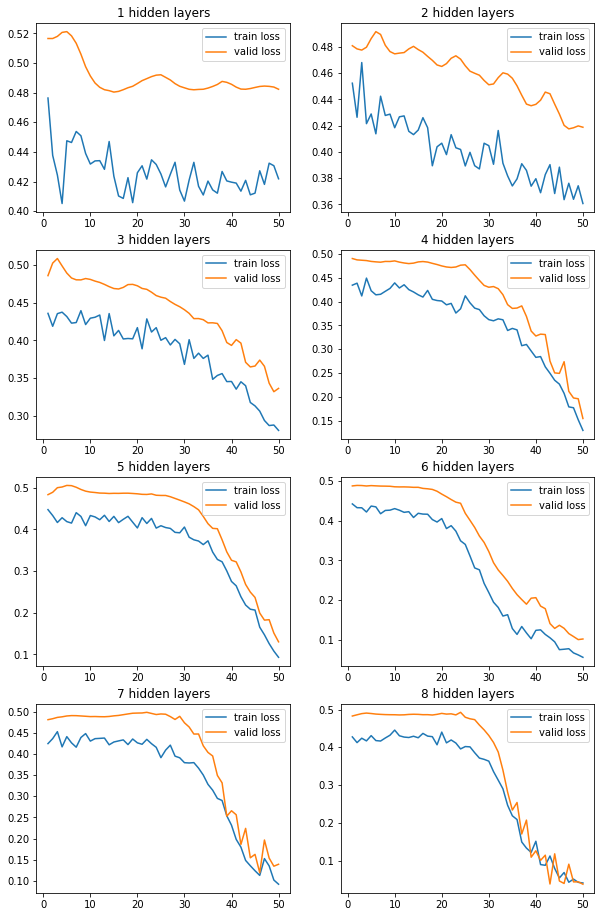

In [32]:
fig, ax = plt.subplots(N_models // 2, 2, figsize=(10,16))

ax = ax.ravel()

for i in range(N_models):
    ax[i].set_title(str(i + 1) + ' hidden layers')
    ax[i].plot(range(1, 51), losses[i + 1]['train'], label = 'train loss')
    ax[i].plot(range(1, 51), losses[i + 1]['valid'], label = 'valid loss')
    ax[i].legend()
fig.show()  

In [33]:
y_nn = [[] for i in range(N_models)]

for k in range(N_models):

    for el in x:

        outp = simple_model[k](torch.FloatTensor([el]))

        y_nn[k].append(outp.item())

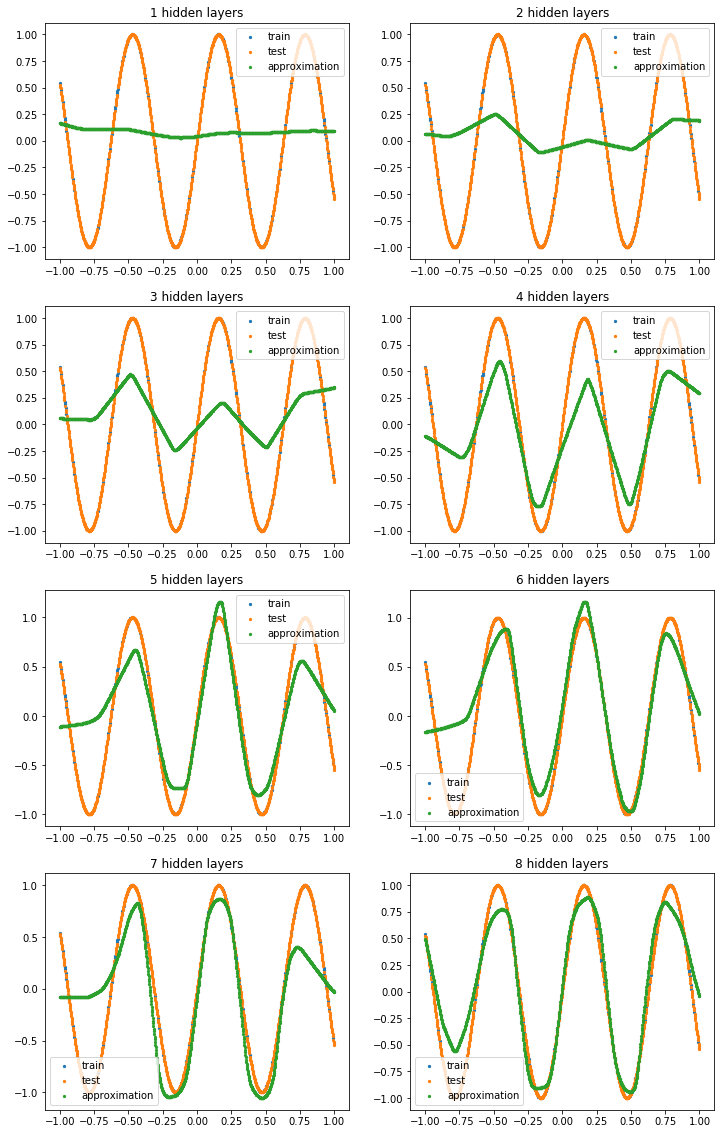

In [34]:
fig, ax = plt.subplots(N_models // 2, 2, figsize=(12,20))

ax = ax.ravel()

for i in range(N_models):
    ax[i].set_title(str(i + 1) + ' hidden layers')
    ax[i].scatter(x[:size], np.sin(10 * x[:size]), s = 5, label='train')
    ax[i].scatter(x[size:], np.sin(10 * x[size:]), s = 5, label='test')
    ax[i].scatter(x, y_nn[i], s = 5, label='approximation')
    ax[i].legend()
fig.show()  